## Matrix Factorization with Deep Neural Networks

In this example, we concatenate the learned User and Item embeddings and flatten them into a vector.

This vector is then fed to a DNN model with 400 hidden neurons.

A single sigmoid output neuron produces a continuous outputs and SGD optimizes weights to minimize MSE.

In this example, we only run for 5 epochs to ensure that it's working as expected. I suggest running on GPU if training for 20+ epochs.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import tensorflow as tf
Model = tf.keras.models.Model
Layers = tf.keras.layers
Input, Dense, Embedding = Layers.Input, Layers.Dense, Layers.Embedding
Concatenate, Flatten, Activation = Layers.Concatenate, Layers.Flatten, Layers.Activation
Dropout, BatchNorm = Layers.Dropout, Layers.BatchNormalization
l2 = tf.keras.regularizers.l2
SGD, Adam = tf.keras.optimizers.SGD, tf.keras.optimizers.Adam

## Load Data

In [2]:
df = pd.read_csv('../../data/movielens/edited_rating.csv')

In [3]:
N = df.userId.max() + 1
M = df.movie_idx.max() + 1

## Create Train/Test

In [4]:
df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

## Initialize Params

In [5]:
K = 10
mu = df_train.rating.mean()
epochs = 5
reg_penalty = 0

## Define Model

In [10]:
# user and movie inputs (batchsize, 1)
u = Input(shape=(1,))
m = Input(shape=(1,))

# user embedding (N, 1, K) 
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg_penalty))(u)
# flat user embedding (N, K)
u_embedding = Flatten()(u_embedding) 

# movie embedding (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg_penalty))(m)
# flat movie embedding (N, K)
m_embedding = Flatten()(m_embedding)

# concat embeddings to feed into DNN (N, 2K)
x = Concatenate()([u_embedding, m_embedding])

x = Dense(400)(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 10)        1384930     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 10)        267440      input_6[0][0]                    
__________________________________________________________________________________________________
flatten_4 

## Compile Model

In [11]:
model.compile(
    loss='mse',
    optimizer=SGD(lr=0.01, momentum=0.9),
    metrics=['mse']
)

## Train Model

In [12]:
r = model.fit(
    x=[df_train.userId.values, df_train.movie_idx.values],
    y=df_train.rating.values - mu,
    epochs=epochs,
    batch_size=128,
    validation_data=(
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values - mu
    )
)

/Users/jujohnson/anaconda3/envs/tf.latest/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16000210 samples, validate on 4000053 samples
Epoch 1/5
16000210/16000210 [==============================] - 1422s 89us/step - loss: 0.9140 - mean_squared_error: 0.9140 - val_loss: 0.8606 - val_mean_squared_error: 0.8606
Epoch 2/5
16000210/16000210 [==============================] - 1411s 88us/step - loss: 0.8309 - mean_squared_error: 0.8309 - val_loss: 0.8070 - val_mean_squared_error: 0.8070
Epoch 3/5
16000210/16000210 [==============================] - 1430s 89us/step - loss: 0.7884 - mean_squared_error: 0.7884 - val_loss: 0.7743 - val_mean_squared_error: 0.7743
Epoch 4/5
16000210/16000210 [==============================] - 1443s 90us/step - loss: 0.7649 - mean_squared_error: 0.7649 - val_loss: 0.7606 - val_mean_squared_error: 0.7606
Epoch 5/5
16000210/16000210 [==============================] - 1432s 89us/step - loss: 0.7523 - mean_squared_error: 0.7523 - val_loss: 0.7512 - val_mean_squared_error: 0.7512


## Plot Results

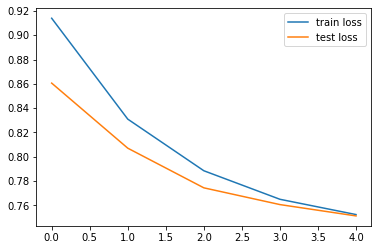

In [13]:
# plot loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

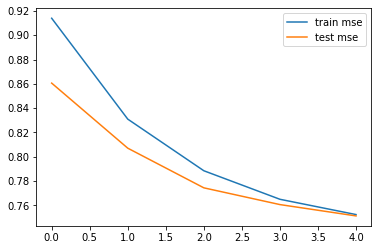

In [14]:
# plot mse
plt.plot(r.history['mean_squared_error'], label='train mse')
plt.plot(r.history['val_mean_squared_error'], label='test mse')
plt.legend()
plt.show()